In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install bhtsne

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html


In [2]:
import torch
import torch_geometric
from torch_geometric.nn import GCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 第五次作业

本次作业我们强化对GAE和VGAE的实践。具体地，我们用它们来完成（无监督）节点分类任务。

## 0. 课后习题

1. 图的自编码器和图卷积神经网络的区别是什么？
2. 图的变分自编码器比起图的自编码器的优点是什么？

1. GAE和GCN的主要区别在于GAE使用了无监督学习来进行训练，而GCN则是标准的监督学习方法。以节点分类任务为例，在GAE的训练过程中无需对节点进行标注，只需要图结构就可以训练网络来获得节点嵌入(特征)；而在GCN中则需要事先知道节点的类别，然后利用监督学习的方式来获得节点嵌入(特征)。

2. VGAE的优点在于它将样本映射为一个正态分布而不是一个固定的向量，因此我们不仅可以将压缩后的节点嵌入作为特征，还可以对它进行采样来生成新的数据(节点、图、邻接矩阵...)；而GAE则只能获得节点的嵌入，不能处理生成任务。

## 1. 定义GAE和VGAE
首先请同学们定义两个类：GAE和VGAE。

In [3]:
class GCNEncoder(torch.nn.Module):
    """GCN组成的编码器"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

class InnerProductDecoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, z, edge_index, sigmoid=True):
        """
        Copy from sample codes.

        参数说明：
        z: 节点表示
        edge_index: 边索引，也就是节点对
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        if sigmoid:
            value = torch.sigmoid(value)
        return value

class GAE(torch.nn.Module):
    """图自编码器。
    """
    def __init__(self, encoder, decoder=None):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        if self.decoder is None:
            self.decoder = InnerProductDecoder()
        
        self.bce = torch.nn.BCEWithLogitsLoss()
    
    def encode(self, *args, **kwargs):
        return self.encoder(*args, **kwargs)
    
    def decode(self, *args, **kwargs):
        return self.decoder(*args, **kwargs)
    
    def loss(self, z, pos_edge_index, neg_edge_index=None):
        ## negative sampling
        if neg_edge_index is None:
            neg_edge_index = torch_geometric.utils.negative_sampling(pos_edge_index, z.size(0))

        pos_pred = self.decode(z, pos_edge_index, sigmoid=False)
        neg_pred = self.decode(z, neg_edge_index, sigmoid=False)
        
        pos_target = torch.ones_like(pos_pred)
        neg_target = torch.zeros_like(neg_pred)

        pred = torch.cat([pos_pred, neg_pred])
        target = torch.cat([pos_target, neg_target])

        return self.bce(pred, target)

In [4]:
class VariationalGCNEncoder(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
    
class VGAE(GAE): 
    """变分自编码器。继承自GAE这个类，可以使用GAE里面定义的函数。
    """

    MAX_LOGSTD = 10
    
    def __init__(self, encoder, decoder=None):
        super().__init__(encoder, decoder)
        pass
    
    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs):
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs) # 编码后的mu和std表示一个分布
        self.__logstd__ = self.__logstd__.clamp(max=VGAE.MAX_LOGSTD) # 这里把std最大值限制一下
        z = self.reparametrize(self.__mu__, self.__logstd__) # 进行reparametrization，这样才能够训练模型
        return z
    
    def kl_loss(self, mu=None, logstd=None):
        """我们给隐变量的分布加上（0，I）高斯变量的先验，即希望隐变量分布服从（0，I）的高斯分布
        这两个分布的差别用KL损失来衡量。"""
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=VGAE.MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1)) # 两个高斯分布之间的KL损失

## 2. 加载数据集

本次作业我们使用Cora数据集。

In [5]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

## copy from sample codes
# 构造一个transform，用于对数据的预处理
transform = T.Compose([
    T.NormalizeFeatures(),  # 对特征进行标准化
    T.ToDevice(device),    # 把数据放到cpu或者gpu上
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,  # 这一步很关键，是在构造链接预测的数据集
                      split_labels=True, add_negative_train_samples=False),])

dataset = Planetoid(root='./data', name='Cora', transform=transform)# 将数据保存在data文件夹下
data = dataset[0]

train_data, val_data, test_data = dataset[0]

##  3. 训练模型

这部分请同学们自由发挥。

In [6]:
### 请大家完成下面这个测试函数 ###
def train(model, data, epochs=1000, variational=False):
    """训练模型
    
    参数说明
    ----
    model: 模型
    data: 数据
    epochs: 训练的周期
    variational: 是否训练VGAE。如果为True，则计算损失函数的时候需要加上kl loss
    """

    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    pos_edge_index = data.pos_edge_label_index.to(device)
    
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for i in range(epochs):
        optimizer.zero_grad()

        ## encode & decode
        z = model.encode(x, edge_index)
        loss = model.loss(z, pos_edge_index)

        if variational:
            loss = loss + (1 / data.num_nodes) * model.kl_loss()

        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch: {i:03d}, Loss_train: {loss.item():.4f}")

### 3.1 GAE

In [7]:
in_channels, out_channels = dataset.num_features, 16
# device = 'cpu' # device = 'cuda'
 
gae_model = GAE(GCNEncoder(in_channels, out_channels))
gae_model = gae_model.to(device)

train(gae_model, train_data, epochs=1000, variational=False)

Epoch: 000, Loss_train: 0.6931
Epoch: 100, Loss_train: 0.4562
Epoch: 200, Loss_train: 0.4318
Epoch: 300, Loss_train: 0.4290
Epoch: 400, Loss_train: 0.4139
Epoch: 500, Loss_train: 0.4083
Epoch: 600, Loss_train: 0.4078
Epoch: 700, Loss_train: 0.4109
Epoch: 800, Loss_train: 0.4002
Epoch: 900, Loss_train: 0.4030


### 3.2 VGAE

In [8]:
in_channels, out_channels = dataset.num_features, 16
# device = 'cpu' # device = 'cuda'

vgae_model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
vgae_model = vgae_model.to(device)

train(vgae_model, train_data, epochs=1000, variational=True)

Epoch: 000, Loss_train: 1.7201
Epoch: 100, Loss_train: 0.5651
Epoch: 200, Loss_train: 0.4794
Epoch: 300, Loss_train: 0.4563
Epoch: 400, Loss_train: 0.4489
Epoch: 500, Loss_train: 0.4412
Epoch: 600, Loss_train: 0.4364
Epoch: 700, Loss_train: 0.4307
Epoch: 800, Loss_train: 0.4360
Epoch: 900, Loss_train: 0.4358


## 4. 测试模型

训练一个线性模型（比如逻辑回归模型）来预测节点的标签，并输出预测准确率。

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

### 请大家完成下面这个测试函数 ###
def evaluate_node_classification(embedding_matrix, labels, train_mask, 
                                 test_mask, normalize_embedding=True, max_iter=1000):
        
    """训练一个线性模型（比如逻辑回归模型）来预测节点的标签
    
    返回值说明
    ----
    preds: 模型预测的标签
    test_acc: 模型预测的准确率
    """

    embedding_matrix = embedding_matrix.cpu().numpy()
    if normalize_embedding:
        embedding_matrix = normalize(embedding_matrix)

    features_train = embedding_matrix[train_mask]
    features_test = embedding_matrix[test_mask]
    labels_train = labels[train_mask]
    labels_test = labels[test_mask]

    clf = LogisticRegression(solver='lbfgs', max_iter=max_iter, multi_class='auto')
    clf.fit(features_train, labels_train)

    preds = clf.predict(features_test)
    test_acc = accuracy_score(labels_test, preds)

    return preds, test_acc

In [10]:
embedding_gae = gae_model.encode(train_data.x, train_data.edge_index).detach()

preds, test_acc = evaluate_node_classification(embedding_gae, train_data.y.cpu().numpy(), train_data.train_mask.cpu().numpy(), train_data.test_mask.cpu().numpy())
print('GAE Test Acc: %.4f' % test_acc)

GAE Test Acc: 0.6720


In [11]:
embedding_vgae = vgae_model.encode(train_data.x, train_data.edge_index).detach()

preds, test_acc = evaluate_node_classification(embedding_vgae, train_data.y.cpu().numpy(), train_data.train_mask.cpu().numpy(), train_data.test_mask.cpu().numpy())
print('VGAE Test Acc: %.4f' % test_acc)

VGAE Test Acc: 0.6890


到这里本次作业就结束了。这次的任务其实是无监督的节点分类问题。可以看到，我们会使用一些和前面DeepWalk作业中相似的代码。同学可以讲DeepWalk和GAE/VGAE的结果做一个比较，看看谁在这个任务上效果更好。

In [12]:
## DeepWalk, copy from previous sample codes
from torch_geometric.nn import Node2Vec
from tqdm.notebook import tqdm

model = Node2Vec(train_data.edge_index, embedding_dim=16, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [13]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test(data):
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

In [14]:
for epoch in range(1, 1000): # 这里使用更大的epoch将提高性能，比如100
    loss = train()

    if epoch % 100 == 0:
        acc = test(train_data)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch: 100, Loss: 0.8256, Acc: 0.5590
Epoch: 200, Loss: 0.8242, Acc: 0.5620
Epoch: 300, Loss: 0.8228, Acc: 0.5590
Epoch: 400, Loss: 0.8232, Acc: 0.5540
Epoch: 500, Loss: 0.8228, Acc: 0.5600
Epoch: 600, Loss: 0.8234, Acc: 0.5650
Epoch: 700, Loss: 0.8227, Acc: 0.5640
Epoch: 800, Loss: 0.8214, Acc: 0.5650
Epoch: 900, Loss: 0.8219, Acc: 0.5700


In [15]:
embedding_deepwalk = model().detach()

preds, test_acc = evaluate_node_classification(embedding_deepwalk, train_data.y.cpu().numpy(), train_data.train_mask.cpu().numpy(), train_data.test_mask.cpu().numpy())
print('DeepWalk Test Acc: %.4f' % test_acc)

DeepWalk Test Acc: 0.5600


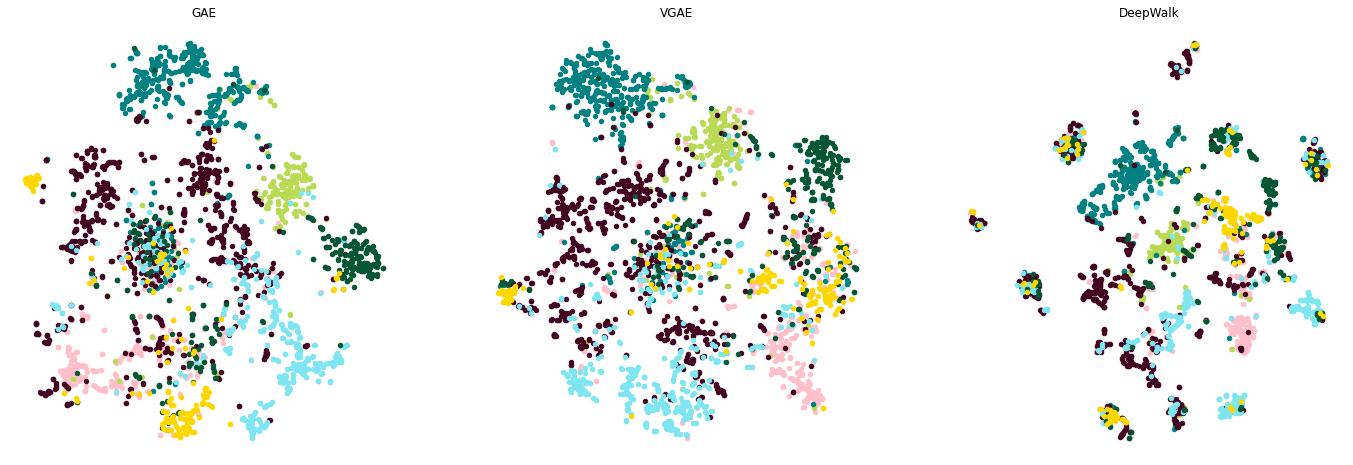

In [16]:
from bhtsne import tsne
import matplotlib.pyplot as plt

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]

y = train_data.y.cpu().numpy()

plt.figure(figsize=(8*3, 8))

## GAE
z = tsne(embedding_gae.cpu().numpy().astype('float64'))
plt.subplot(1,3,1)
for i in range(dataset.num_classes):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
plt.axis('off')
plt.title("GAE")

## VGAE
z = tsne(embedding_vgae.cpu().numpy().astype('float64'))
plt.subplot(1,3,2)
for i in range(dataset.num_classes):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
plt.axis('off')
plt.title("VGAE")

## DeepWalk
z = tsne(embedding_deepwalk.cpu().numpy().astype('float64'))
plt.subplot(1,3,3)
for i in range(dataset.num_classes):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
plt.axis('off')
plt.title("DeepWalk")
plt.show()